## Determinism

In [1]:
from determinism import Determinism

determinism = Determinism(seed=42).sow()  # Keep this before any torch import
print("Training results should now be reproducible.")

Training results should now be reproducible.


## Train model on imbalanced dataset with Standard Cross-Entropy

We train a model using parameters from previous exercise (TODO) on a dataset where we retain only 20% of training images for each cat breed. We expect it to be biased toward dog breeds or majority classes due to the class imbalance. We observe that the validation accuracy is low (70%).

Training with params:
{
  "seed": 42,
  "architecture": "resnet50",
  "optimizer": {
    "learning_rate": 0.001,
    "weight_decay": 0,
    "name": "adam"
  },
  "n_epochs": 3,
  "freeze_layers": true,
  "validation_freq": 1,
  "augmentation": {
    "enabled": false
  },
  "unsup_weight": 0.5,
  "masked_finetune": false,
  "mask_K": 1,
  "contrastive_temp": 0.1
}


100%|██████████| 791918971/791918971 [00:26<00:00, 29942885.86it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 16223029.15it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet
Creating balanced split...


  0%|          | 0/3680 [00:00<?, ?it/s]

Creating balanced split...


  0%|          | 0/1359 [00:00<?, ?it/s]

Update step:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/3], Loss: 2.2155, Train Acc: 56.71%, Val Acc: 68.66%
Epoch [2/3], Loss: 0.9590, Train Acc: 90.72%, Val Acc: 69.85%
Epoch [3/3], Loss: 0.5751, Train Acc: 91.69%, Val Acc: 69.85%
Total elapsed: 14.39s, average per update step: 0.09s
[Trainer] Saved checkpoint to runs/checkpoints/46c865c6ab21c0c3aaf9ae21aedb2ad6.pth
Training result:
{
  "training_losses": [2.2155186299121743, 0.959030239871054, 0.5750558863986622],
  "training_accuracies": [0.5671497584541063, 0.9072463768115943, 0.9169082125603865],
  "validation_accuracies": [0.6865671641791045, 0.6985074626865672, 0.6985074626865672],
  "update_steps": [33, 66, 99],
  "epochs": [1, 2, 3],
  "training_elapsed": 14.394215334999899
}


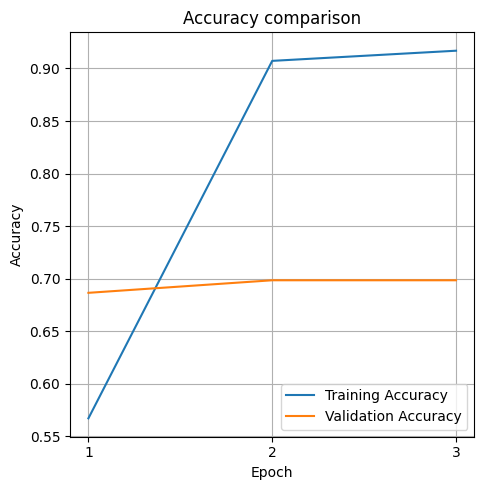

In [2]:
from typing import Literal
import augmentation
from augmentation import AugmentationParams

%reload_ext autoreload
%autoreload 2

from training import TrainParams, AdamParams
from evaluation import evaluate_test_accuracy_and_misclassified, \
    evaluate_with_train_val_plot, run_with_different_seeds
from run import run
from caching import invalidate_cache_entry
from datasets import DatasetParams

dataset_params = DatasetParams(
    splitting_seed=determinism.seed,
    shuffler_seed=determinism.seed,
    batch_size=32,
    class_fractions = (0.2,)*25 + (1.0,)*12, # use 20 % of cat samples
    validation_set_fraction=0.2,  # Use 20% of trainval set for validation
)

architecture: Literal["resnet18", "resnet34", "resnet50"] = "resnet50"
baseline_params = TrainParams(
    seed=determinism.seed,
    architecture=architecture,
    n_epochs=3,
    optimizer=AdamParams(
        learning_rate=1e-3,
        weight_decay=0,
    ),
    freeze_layers=True,
    unfreezing_epochs=None,
    augmentation=AugmentationParams(
        enabled=False,
        transform=None,
    ),
    validation_freq=1,
    time_limit_seconds=None,
    val_acc_target=None,
)

run_args = (dataset_params, baseline_params, determinism)

# Set invalidate=True to invalidate a single cache entry
invalidate_cache_entry(run, run_args, invalidate=False)

# First plot: Training and validation accuracy
print("Training with params:")
print(baseline_params.pprint())
result = run(*run_args)

print("Training result:")
print(result.pprint())
evaluate_with_train_val_plot(result)

## Test imbalanced model

What happens to the final test performance on the classes with limited data? It is not enough to just train 

In [9]:
from run import try_loading_trainer
from evaluation import evaluate_predictions
from torch.utils.data import DataLoader
from datasets import load_dataset
from training import Trainer
from util import suppress_weights_only_warning

suppress_weights_only_warning()

trainer = try_loading_trainer(dataset_params, baseline_params, determinism)

test_dataset = load_dataset("test", Trainer.make_base_transform(baseline_params))
test_loader = DataLoader(
    test_dataset,
    batch_size=dataset_params.batch_size,
    shuffle=False,
    num_workers=3,
    persistent_workers=False,
    pin_memory=True,
    worker_init_fn=Determinism.data_loader_worker_init_fn(dataset_params.shuffler_seed),
)
print(f"Test size: {len(test_loader.dataset)}")

predicted, truth, _ = evaluate_predictions(trainer, test_loader, test_dataset)

from sklearn.metrics import classification_report

print(classification_report(truth, predicted, target_names=test_dataset.class_to_idx.keys()))

print(test_dataset.class_to_idx)

Trying to load trainer from disk...
[Trainer] Loaded checkpoint from runs/checkpoints/46c865c6ab21c0c3aaf9ae21aedb2ad6.pth (epoch 3)
Test size: 3669


Evaluating:   0%|          | 0/115 [00:00<?, ?it/s]

                            precision    recall  f1-score   support

                Abyssinian       0.00      0.00      0.00        98
          American Bulldog       0.00      0.00      0.00       100
 American Pit Bull Terrier       0.00      0.00      0.00       100
              Basset Hound       0.00      0.00      0.00       100
                    Beagle       0.00      0.00      0.00       100
                    Bengal       0.00      0.00      0.00       100
                    Birman       0.00      0.00      0.00       100
                    Bombay       0.00      0.00      0.00        88
                     Boxer       0.00      0.00      0.00        99
         British Shorthair       0.00      0.00      0.00       100
                 Chihuahua       0.00      0.00      0.00       100
              Egyptian Mau       0.00      0.00      0.00        97
    English Cocker Spaniel       0.00      0.00      0.00       100
            English Setter       0.00      0.00

/opt/python/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/python/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/python/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Compensate using weighted cross-entropy and/or over-sampling